# Import Models and Set Params

In [51]:
from parse_utils import parse_tuple_output, parse_dependency_output, parse_question_output
from PIL import Image
from pprint import pprint
from query_utils import generate_dsg
from copy import deepcopy

# load LLM
import openai
from openai_utils import openai_setup, openai_completion
openai_setup()
assert openai.api_key is not None

# load vqa model:
from vqa_utils import MPLUG
print("Loading mPLUG-large")
vqa_model = MPLUG()

Read key from /local1/bryanzhou008/ecole/keys/_OAI_KEY.txt
Loading mPLUG-large


2024-01-11 13:54:10,782 - modelscope - WARNING - Model revision not specified, use revision: v1.0.0
2024-01-11 13:54:11,138 - modelscope - INFO - initiate model from /home/bryanzhou008/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en
2024-01-11 13:54:11,139 - modelscope - INFO - initiate model from location /home/bryanzhou008/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en.
2024-01-11 13:54:11,141 - modelscope - INFO - initialize model from /home/bryanzhou008/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en


load checkpoint from /home/bryanzhou008/.cache/modelscope/hub/damo/mplug_visual-question-answering_coco_large_en/pytorch_model.bin
<All keys matched successfully>


In [52]:
# INPUT_TEXT_PROMPT = "A baby is sleeping on a covered mattress. His shirt is black white and blue. The mattress cover has designs all over it. There is a doll with a blue and purple hoody nearby."
# INPUT_TEXT_PROMPT = "open top canoe with elevated bench seats, symmetrical pointed bow and stern, wide beam, prominent wooden gunwales"
# INPUT_TEXT_PROMPT = "a yellow 22-spot ladybug with black spots on a green leaf"
INPUT_TEXT_PROMPT = "a man sitting in a dark green open top canoe, the canoe has elevated bench seats, symmetrical pointed bow and stern, wide beam, prominent wooden gunwales"

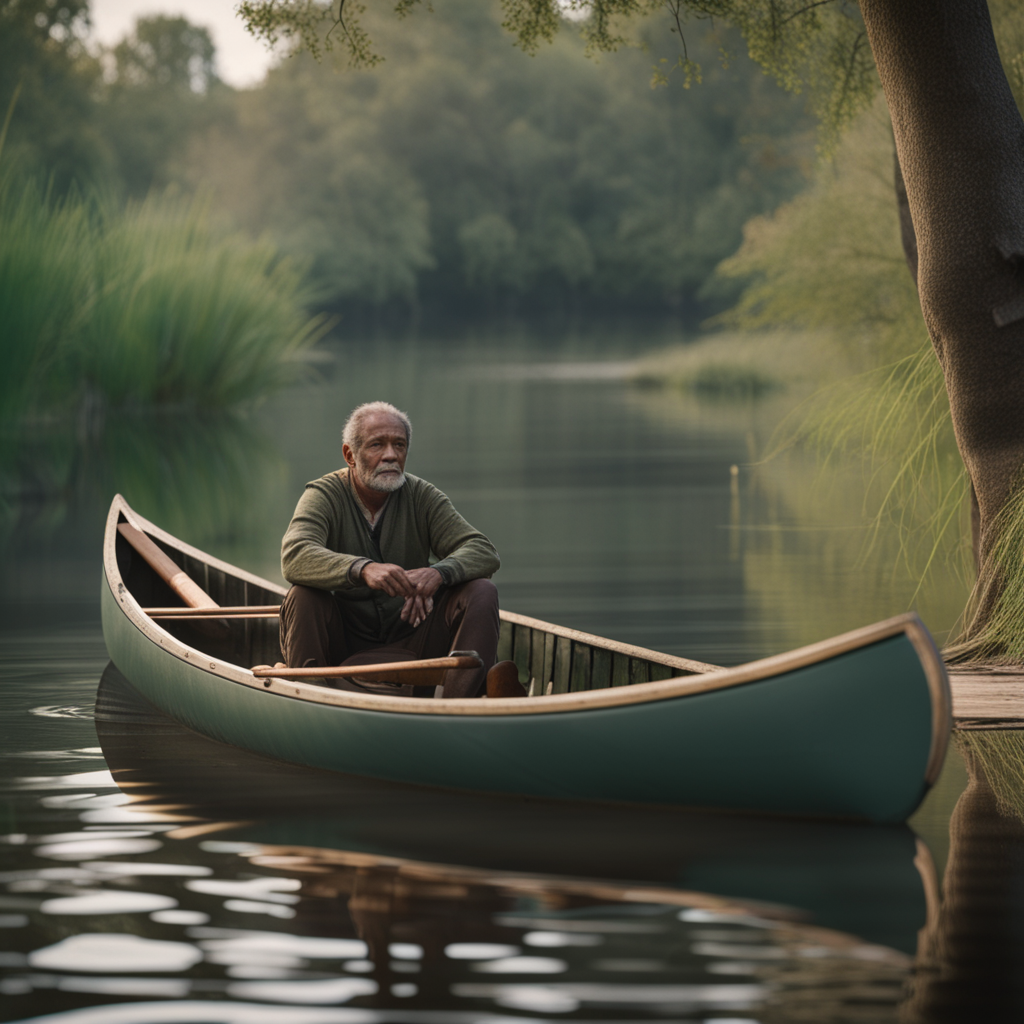

In [53]:
# generated_image = Image.open("example_img.png")
# generated_image = Image.open("/local1/bryanzhou008/ecole/data/Demo/output/canoe1/0.png")
# generated_image = Image.open("/local1/bryanzhou008/ecole/data/Demo/output/22-spot-lady-bug/1.png")
generated_image = Image.open("/local1/bryanzhou008/ecole/data/Demo/output/canoe2_new/1.png")
generated_image

# End to End DSG Evaluation

In [54]:
def evaluate_image_dsg(text_prompt, generated_image, VQA, LLM, verbose=True):
    """evaluate a generated image with DSG"""
    
    if verbose:
        print("#"*50)
        print("1) Generate DSG from text with LLM")
        print("#"*50)
    id2prompts = {
        'custom_0': {
            'input': text_prompt,
        }
    }

    id2tuple_outputs, id2question_outputs, id2dependency_outputs = generate_dsg(
        id2prompts, generate_fn=LLM,
        verbose=verbose
        
    )
    qid2tuple = parse_tuple_output(id2tuple_outputs['custom_0']['output'])
    qid2dependency = parse_dependency_output(id2dependency_outputs['custom_0']['output'])
    qid2question = parse_question_output(id2question_outputs['custom_0']['output'])
        
    if verbose:
        print("#"*50)
        print("2) Answer questions given the generated image, with VQA")
        print("#"*50)

    qid2answer = {}
    qid2scores = {}

    for id, question in qid2question.items():
        answer = VQA(generated_image, question)
        qid2answer[id] = answer
        qid2scores[id] = float(answer == 'yes')
            
    average_score_without_dep = sum(qid2scores.values()) / len(qid2scores)
        
    if verbose:
        print("#"*50)
        print("3) Zero-out scores from invalid questions")
        print("#"*50)
        
 
    # 3) zero-out scores from invalid questions 
    qid2validity = {}
    qid2scores_after_filtering = deepcopy(qid2scores)

    for id, parent_ids in qid2dependency.items():
        # zero-out scores if parent questions are answered 'no'
        any_parent_answered_no = False
        for parent_id in parent_ids:
            if parent_id == 0:
                continue
            if qid2scores[parent_id] == 0:
                any_parent_answered_no = True
                break
        if any_parent_answered_no:
            qid2scores_after_filtering[id] = 0.0
            qid2validity[id] = False
        else:
            qid2validity[id] = True
            
    if verbose:
        print("Per-quesiton eval results (after using dependency)")
        for id in qid2question:
            print("ID", id)
            print("question", qid2question[id])
            print("answer", qid2answer[id])
            print("validity", qid2validity[id])
            print("score (before filtering)", qid2scores[id])
            print("score (after filtering)", qid2scores_after_filtering[id])
            print()
        

    if verbose:
        print("#"*50)
        print("4) Calculate the final score by averaging")
        print("#"*50)

    average_score_with_dep = sum(qid2scores_after_filtering.values()) / len(qid2scores)
        
    return {
        'qid2tuple': qid2tuple,
        'qid2dependency': qid2dependency,
        'qid2question': qid2question,
        'qid2answer': qid2answer,
        'qid2scores': qid2scores,
        'qid2validity': qid2validity,
        'average_score_with_dependency': average_score_with_dep,
        'average_score_without_dependency': average_score_without_dep
    }

In [55]:
eval_out = evaluate_image_dsg(
    text_prompt=INPUT_TEXT_PROMPT,
    generated_image=generated_image,
    VQA=vqa_model.vqa,
    LLM=openai_completion,
    # verbose=False
)

pprint(eval_out)

##################################################
1) Generate DSG from text with LLM
##################################################
Task 1:  tuple
Run inference


Preparing LM inputs: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 5745.62it/s]


Running LM calls with 1 workers.


Postprocessing LM outputs: 100%|███████████████████████████| 1/1 [00:00<00:00, 16256.99it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'a man sitting in a dark green open top canoe, the canoe has '
          'elevated bench seats, symmetrical pointed bow and stern, wide beam, '
          'prominent wooden gunwales',
 'output': '1 | entity - whole (man)\n'
           '2 | entity - whole (canoe)\n'
           '3 | attribute - color (canoe, dark green)\n'
           '4 | attribute - state (canoe, open top)\n'
           '5 | attribute - state (canoe, elevated bench seats)\n'
           '6 | attribute - state (canoe, symmetrical pointed bow and stern)\n'
           '7 | attribute - state (canoe, wide beam)\n'
           '8 | attribute - state (canoe, prominent wooden gunwales)\n'
           '9 | relation - spatial (man, canoe, in)'}
Task 2:  question
Run inference


Preparing LM inputs: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 5343.06it/s]


Running LM calls with 1 workers.


Postprocessing LM outputs: 100%|███████████████████████████| 1/1 [00:00<00:00, 18893.26it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'a man sitting in a dark green open top canoe, the canoe has '
          'elevated bench seats, symmetrical pointed bow and stern, wide beam, '
          'prominent wooden gunwales\n'
          '1 | entity - whole (man)\n'
          '2 | entity - whole (canoe)\n'
          '3 | attribute - color (canoe, dark green)\n'
          '4 | attribute - state (canoe, open top)\n'
          '5 | attribute - state (canoe, elevated bench seats)\n'
          '6 | attribute - state (canoe, symmetrical pointed bow and stern)\n'
          '7 | attribute - state (canoe, wide beam)\n'
          '8 | attribute - state (canoe, prominent wooden gunwales)\n'
          '9 | relation - spatial (man, canoe, in)',
 'output': '1 | Is there a man?\n'
           '2 | Is there a canoe?\n'
           '3 | Is the canoe dark green?\n'
           '4 | Is the canoe open top?\n'
           '5 | Does the canoe have elevated bench seats?\n'
           '6 | Does the 

Preparing LM inputs: 100%|██████████████████████████████████| 1/1 [00:00<00:00, 4485.89it/s]


Running LM calls with 1 workers.


Postprocessing LM outputs: 100%|███████████████████████████| 1/1 [00:00<00:00, 24244.53it/s]


Sample results:
id: custom_0
{'id': 'custom_0',
 'input': 'a man sitting in a dark green open top canoe, the canoe has '
          'elevated bench seats, symmetrical pointed bow and stern, wide beam, '
          'prominent wooden gunwales\n'
          '1 | entity - whole (man)\n'
          '2 | entity - whole (canoe)\n'
          '3 | attribute - color (canoe, dark green)\n'
          '4 | attribute - state (canoe, open top)\n'
          '5 | attribute - state (canoe, elevated bench seats)\n'
          '6 | attribute - state (canoe, symmetrical pointed bow and stern)\n'
          '7 | attribute - state (canoe, wide beam)\n'
          '8 | attribute - state (canoe, prominent wooden gunwales)\n'
          '9 | relation - spatial (man, canoe, in)',
 'output': '1 | 0\n2 | 0\n3 | 2\n4 | 2\n5 | 2\n6 | 2\n7 | 2\n8 | 2\n9 | 1,2'}
##################################################
2) Answer questions given the generated image, with VQA
##################################################
########